In [76]:
import pandas as pd
from read_data import read_data
import numpy as np

def compute_delta_metrics(data):
    """
    Computes additional metrics for the dataset:
    - Delta Position: Leader's position minus Follower's position.
    - Delta Velocity: Leader's velocity minus Follower's velocity.
    - Delta Acceleration: Leader's acceleration minus Follower's acceleration.
    - Time-To-Collision (TTC): Delta Position divided by Delta Velocity.
    """
    data["delta_position"] = data["x_leader"] - data["x_follower"]
    data["delta_velocity"] = data["v_follower"] - data["v_leader"]
    data["delta_acceleration"] = data["a_follower"] - data["a_leader"]
    data["TTC"] = data["delta_position"] / data["delta_velocity"]
    data.loc[data["TTC"] < 0, "TTC"] = np.nan
    data['time_headway'] = data['delta_position'] / data['v_follower']
    data['TTC_min'] = data['TTC']

    # Calculate jerk for the follower vehicle
    data['jerk_follower'] = np.gradient(data['a_follower'], data['time'])
    return data

def aggregate_data_by_case(data):
    """
    Aggregates the dataset by 'case_id' to find the max and min 
    of each delta metric and TTC for each case.
    Renames columns for clarity and adds case_id as a column.
    """
    aggr_data = data.groupby('case_id').agg({'delta_velocity':'mean',
                           'v_follower':'max',
                           'delta_acceleration':'mean',
                           'a_follower':'max',
                           'jerk_follower':'mean',
                           'time_headway':'median',
                           'delta_position':'min',
                           'TTC':'median',
                           'TTC_min':'min'}).reset_index()

    return aggr_data

def adjust_ttc_sign(aggregated_data):
    """
    Ensures TTC (Time-To-Collision) is non-negative by taking the absolute value.
    """
    aggregated_data["TTC"] = aggregated_data["TTC"].abs()
    aggregated_data["TTC_min"] = aggregated_data["TTC_min"].abs()
    return aggregated_data

def convert_df(dataset: str, mode: str):
    """
    Main function that utilizes the above helper functions to preprocess the data.
    Returns a DataFrame grouped by 'case_id' with max and min values of
    delta position, delta velocity, delta acceleration, and TTC (Time-To-Collision).
    """
    data = read_data(dataset, mode)
    data = compute_delta_metrics(data)
    aggregated_data = aggregate_data_by_case(data)
    aggregated_data = adjust_ttc_sign(aggregated_data)
    return aggregated_data


In [77]:
trainHA = convert_df("HA", "train")
trainHA.head(500)

,case_id,delta_velocity,v_follower,delta_acceleration,a_follower,jerk_follower,time_headway,delta_position,TTC,TTC_min
0,0,-0.585128,11.712142,0.047007,2.369844,-0.028677,1.697374,9.428864,61.144338,16.595543
1,1,-0.109332,14.526137,0.039523,0.837482,-0.022997,1.499226,18.421163,80.305906,20.562361
2,2,-0.717295,13.135771,-0.140948,1.012260,0.010870,3.379581,16.096035,7.636726,5.728496
3,3,1.121150,15.083161,0.026782,0.394586,-0.018426,1.937762,22.154348,25.245706,18.166619
4,4,0.587793,14.517350,-0.022323,0.667001,-0.018814,2.044764,14.362037,36.424020,7.093686
...,...,...,...,...,...,...,...,...,...,...
495,495,0.197079,14.385285,-0.088729,0.305779,-0.006375,2.179975,27.189289,59.974457,29.818995
496,496,1.227572,12.163433,-0.068099,0.397671,0.018117,2.446065,6.359919,11.324800,3.282347
497,497,0.317125,14.519390,-0.096140,1.157213,-0.019941,1.829167,17.585190,29.175127,7.392851
498,498,0.278913,14.095021,-0.065379,0.344991,-0.036504,1.402545,15.717958,33.327711,16.101418


In [50]:
selected_features = trainHA


/Users/ykong/.local/share/virtualenvs/car-following-project--ZycwsGt/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


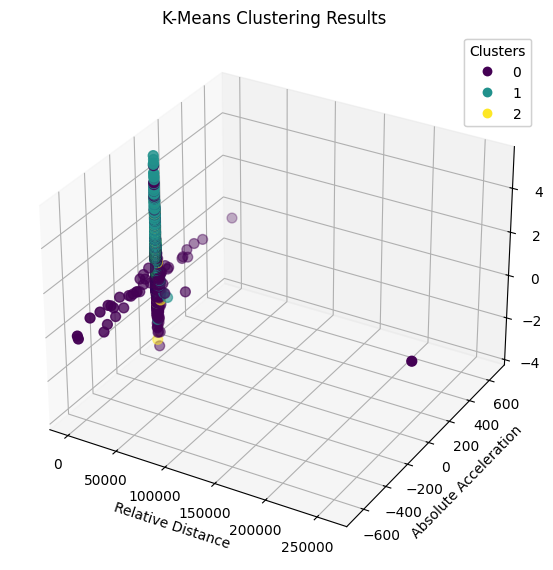

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


# use linear standardization to normalize the data
scaler = StandardScaler()
selected_features.dropna(inplace=True)
scaled_data = scaler.fit_transform(selected_features.drop(['case_id'], axis=1))

kmeans = KMeans(n_clusters=3, random_state=42)
selected_features['cluster'] = kmeans.fit_predict(scaled_data)



# K-Means results

fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(selected_features['TTC'], 
                       selected_features['time_headway'], 
                       selected_features['delta_velocity'], 
                       c=selected_features['cluster'], 
                       cmap='viridis', 
                       s=50)

ax1.set_xlabel('Relative Distance')
ax1.set_ylabel('Absolute Acceleration')
ax1.set_zlabel('Relative Velocity')
ax1.set_title('K-Means Clustering Results')
legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
ax1.add_artist(legend1)

/Users/ykong/.local/share/virtualenvs/car-following-project--ZycwsGt/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ykong/.local/share/virtualenvs/car-following-project--ZycwsGt/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ykong/.local/share/virtualenvs/car-following-project--ZycwsGt/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yko

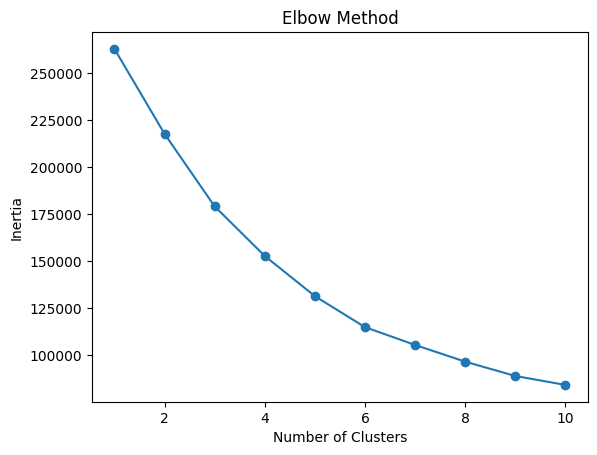

/Users/ykong/.local/share/virtualenvs/car-following-project--ZycwsGt/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


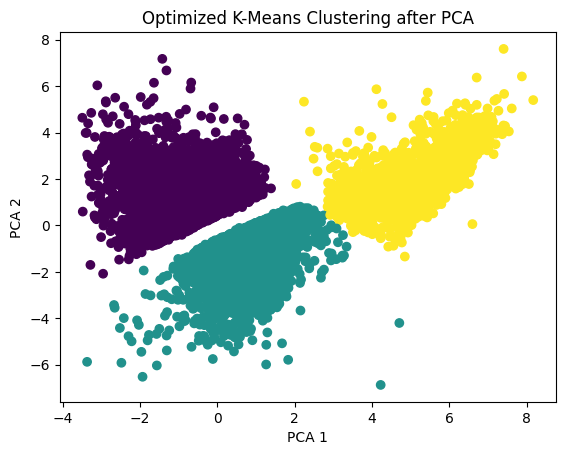

The average silhouette_score is : 0.5786472697027952


In [71]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Elbow Method to find optimal number of clusters
inertia_list = []
range_n_clusters = list(range(1, 11))  

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia_list.append(kmeans.inertia_)

plt.plot(range_n_clusters, inertia_list, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# define the optimal number of clusters
optimal_clusters = 3 

# PCA to visualize the data in 2D
pca = PCA(n_components=2)  
pca_data = pca.fit_transform(scaled_data)

# K-Means with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
selected_features['cluster'] = kmeans.fit_predict(pca_data)

# plot the results
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=selected_features['cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Optimized K-Means Clustering after PCA')
plt.show()

# Silhouette Score
silhouette_avg = silhouette_score(pca_data, selected_features['cluster'])
print("The average silhouette_score is :", silhouette_avg)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import math

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        X.append(data[i:end_ix, :])
        y.append(data[end_ix:out_end_ix, :])
    return np.array(X), np.array(y)

def preprocess_data(df, n_steps_in, n_steps_out, test_size=0.2):
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(df.values)
    X, y = create_sequences(data_normalized, n_steps_in, n_steps_out)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return (
        torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32),
        scaler
    )

def train_model(model, X_train_tensor, y_train_tensor, epochs, optimizer, loss_function):
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = loss_function(y_pred, y_train_tensor[:,0,:])
        loss.backward()
        optimizer.step()
        if epoch%10 == 0:
            tqdm.write(f'epoch: {epoch} loss: {loss.item():.8f}')

def evaluate_model(model, X_test_tensor, y_test_tensor, scaler):
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)
        y_test_pred_np = scaler.inverse_transform(y_test_pred.numpy())
        y_test_actual_np = scaler.inverse_transform(y_test_tensor[:, 0, :].numpy())
        
        mse = mean_squared_error(y_test_actual_np, y_test_pred_np)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test_actual_np, y_test_pred_np)
    
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    
    return mse, rmse, mae

# Usage
# Assume df is your DataFrame
n_steps_in, n_steps_out = 3, 1
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler = preprocess_data(df, n_steps_in, n_steps_out)

model = LSTMModel(input_size=X_train_tensor.shape[2], hidden_layer_size=50, output_size=X_train_tensor.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

train_model(model, X_train_tensor, y_train_tensor, epochs=100, optimizer=optimizer, loss_function=loss_function)
evaluate_model(model, X_test_tensor, y_test_tensor, scaler)


  1%|          | 1/100 [00:02<04:14,  2.57s/it]

epoch: 0 loss: 0.25693053


 11%|█         | 11/100 [00:19<02:24,  1.62s/it]

epoch: 10 loss: 0.20324090


 21%|██        | 21/100 [00:37<02:02,  1.55s/it]

epoch: 20 loss: 0.14432567


 31%|███       | 31/100 [00:51<01:36,  1.40s/it]

epoch: 30 loss: 0.06971581


 41%|████      | 41/100 [01:05<01:21,  1.38s/it]

epoch: 40 loss: 0.02989057


 51%|█████     | 51/100 [01:18<01:07,  1.38s/it]

epoch: 50 loss: 0.02340989


 61%|██████    | 61/100 [01:32<00:53,  1.38s/it]

epoch: 60 loss: 0.02211207


 71%|███████   | 71/100 [01:48<00:44,  1.54s/it]

epoch: 70 loss: 0.02031287


 81%|████████  | 81/100 [02:02<00:26,  1.39s/it]

epoch: 80 loss: 0.01932445


 91%|█████████ | 91/100 [02:16<00:12,  1.41s/it]

epoch: 90 loss: 0.01827779


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]

Mean Squared Error (MSE): 963597828096.00
Root Mean Squared Error (RMSE): 981630.19
Mean Absolute Error (MAE): 207429.59


(963597800000.0, 981630.1890712205, 207429.6)

In [ ]:
eval_df = convert_df("HA", "val")
